# ADA / Applied Data Analysis
<h2 style="color:#a8a8a8">Homework 4 - Applied Machine Learning<br>
Aimée Montero, Alfonso Peterssen, Cyriaque Brousse</h2>

## Assignment description
In this homework we will gain experience on Applied Machine Learning, exploring an interesting dataset about soccer players and referees.
Given that the focus of this homework is Machine Learning, I recommend you to first take a look at [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)
containing a solid work in pre-processing + visualization of the given dataset. You are *not* allowed to just copy/paste the pre-processing steps
performed by the notebook authors -- you are still supposed to perform your own data analysis for the homework. Still, I'm confident that consulting first
the work done by expert data analysts will speed up tangibly your effort (i.e., they have already found for you many glitches in the data :)


### Assignment
1. Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters 
passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model,
inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

  *BONUS*: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition
your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?<br><br>

2. Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint
clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette
score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

## Data description

From a company for sports statistics, we obtained data and profile photos from all soccer players (N = 2053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3147) that these players played under in their professional career. We created a dataset of player–referee dyads including the number of matches players and referees encountered each other and our dependent variable, the number of red cards given to a player by a particular referee throughout all matches the two encountered each other.
 
Player photos were available from the source for 1586 out of 2053 players. Players’ skin tone was coded by two independent raters blind to the research question who, based on their profile photo, categorized players on a 5-point scale ranging from “very light skin” to “very dark skin” with “neither dark nor light skin” as the center value. 

Additionally, implicit bias scores for each referee country were calculated using a race implicit association test (IAT), with higher values corresponding to faster white | good, black | bad associations. Explicit bias scores for each referee country were calculated using a racial thermometer task, with higher values corresponding to greater feelings of warmth toward whites versus blacks. Both these measures were created by aggregating data from many online users in referee countries taking these tests on [Project Implicit](http://projectimplicit.net).

In all, the dataset has a total of 146028 dyads of players and referees. A detailed description of all variables in the dataset can be seen in the list below.

### Variables:

- *playerShort* - short player ID
- *player* - player name
- *club* - player club
- *leagueCountry* - country of player club (England, Germany, France, and Spain)
- *birthday* - player birthday
- *height* - player height (in cm)
- *weight* - player weight (in kg)
- *position* - detailed player position
- *games* - number of games in the player-referee dyad
- *victories* - victories in the player-referee dyad
- *ties* - ties in the player-referee dyad
- *defeats* - losses in the player-referee dyad
- *goals* - goals scored by a player in the player-referee dyad
- *yellowCards* - number of yellow cards player received from referee
- *yellowReds* - number of yellow-red cards player received from referee
- *redCards* - number of red cards player received from referee
- *photoID* - ID of player photo (if available)
- *rater1* - skin rating of photo by rater 1 (5-point scale ranging from “very light skin” to “very dark skin”)
- *rater2* - skin rating of photo by rater 2 (5-point scale ranging from “very light skin” to “very dark skin”)
- *refNum* - unique referee ID number (referee name removed for anonymizing purposes)
- *refCountry* - unique referee country ID number (country name removed for anonymizing purposes)
- *meanIAT* - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations
- *nIAT* - sample size for race IAT in that particular country
- *seIAT* - standard error for mean estimate of race IAT
- *meanExp* - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks
- *nExp* - sample size for explicit bias in that particular country
- *seExp* - standard error for mean estimate of explicit bias measure

## Part 0 - Data preprocessing

Let's import the required libraries:

In [126]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as pl
%matplotlib inline
import seaborn as sb
import warnings

### 0a - Importing the data

And import the data from the CSV source:

In [127]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv', parse_dates=['birthday'], infer_datetime_format=True)
full_data_length = len(data)

#### Referees with less than 22 entries

As explained in [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we need to discard referees for which there are less than 22 entries.

In [128]:
referees = data.refNum.value_counts()
referees_good = referees[referees > 21]

We see that the proportion of referees with less than 22 entries is:

In [129]:
1 - len(referees_good) / len(referees)

0.682872577057515

We lose 68% of the referees, but we keep 91% of the dyads:

In [130]:
data = data[data.refNum.isin(referees_good.index.values)]
len(data) / full_data_length

0.914215082039061

### 0b - Exploring features

We would drop the following proportion of the data if we discard all `null` values:

In [131]:
1 - len(data.dropna()) / len(data)

0.20913701020966136

#### Skin color ratings

In [132]:
len(data[data.rater1.isnull() | data.rater2.isnull()]) / len(data)

0.14710751230327862

We need to throw away 15% of the dataset, because for these entries we do not have information about the skin color.

In [133]:
data_skin = data.dropna(how='all', subset=['rater1', 'rater2'])

We have the following possible values in `rater1` and `rater2` fields.

In [134]:
data_skin.rater1.value_counts().sort_index()

0.00    45490
0.25    40053
0.50    12218
0.75     8798
1.00     7303
Name: rater1, dtype: int64

We need to somehow reconcile the two `rater` columns. We choose the average function, and we put the result on an integer scale:

In [135]:
data_skin['skin'] = ((data_skin.rater1 + data_skin.rater2) / 2)
data_skin = data_skin.drop('rater1', axis=1)
data_skin = data_skin.drop('rater2', axis=1)

# Create two new binary feature for skin color.
data_skin['darker_skin'] = data_skin['skin'] <= 0.5

/home/mukel/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


This is what we get for the `skin` field. The higher the value, the "darker" the skin is.

We also added a binary 'darker_skin' for binary classification.

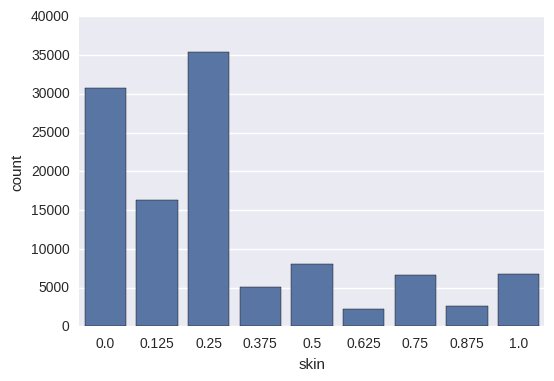

In [136]:
plot_color = sb.color_palette()[0]
sb.countplot(x='skin', data=data_skin, color=plot_color);

#### Age of players

Next, we want to convert the birthday (type `datetime` that scikit-learn does not understand) into the player's age:

In [137]:
import datetime
now = datetime.date.today()

data_skin['age'] = [now.year - b.year for b in data_skin.birthday]
data_skin = data_skin.drop('birthday', axis=1)

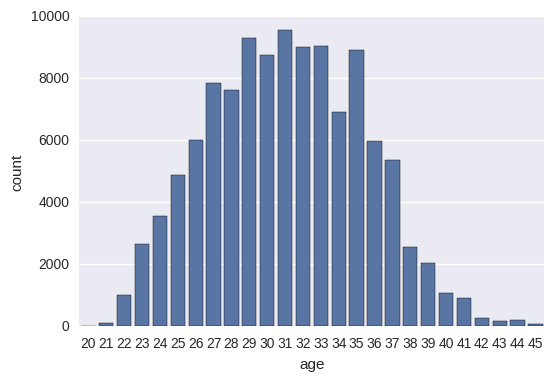

In [138]:
sb.countplot(x='age', data=data_skin, color=plot_color)

We notice that the `age` data approximately follows a normal distribution, and that there are no outliers.

#### Weight

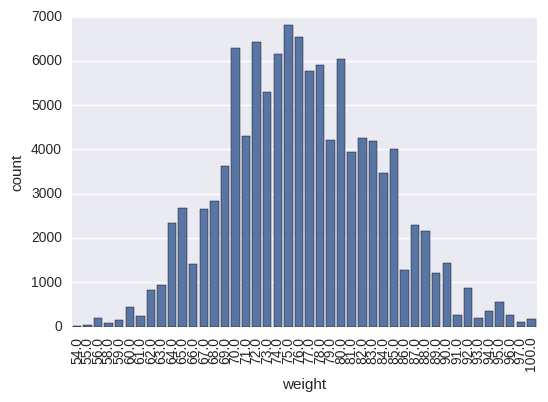

In [139]:
hist = sb.countplot(x='weight', data=data_skin, color=plot_color)
pl.setp(hist.get_xticklabels(), rotation=90)
hist

This also looks normally distributed and there are no outliers.

#### Height

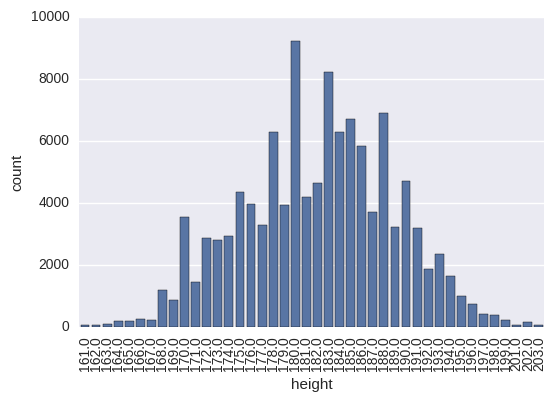

In [140]:
hist = sb.countplot(x='height', data=data_skin, color=plot_color)
pl.setp(hist.get_xticklabels(), rotation=90)
hist

This also looks normally distributed and there are no outliers.

#### Country of league

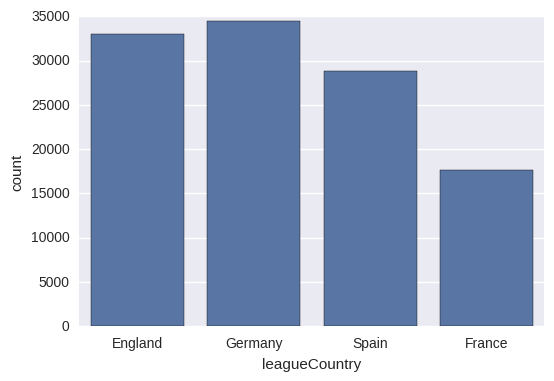

In [141]:
sb.countplot(x='leagueCountry', data=data_skin, color=plot_color)

#### Position on the field

In [142]:
data_skin.position.isnull().sum() / len(data_skin)

0.06779259103124835

7% of the entries miss a `position` information. We will replace these null values by a `Missing` entry.

In [143]:
data_skin.position = data_skin.position.fillna('Missing')

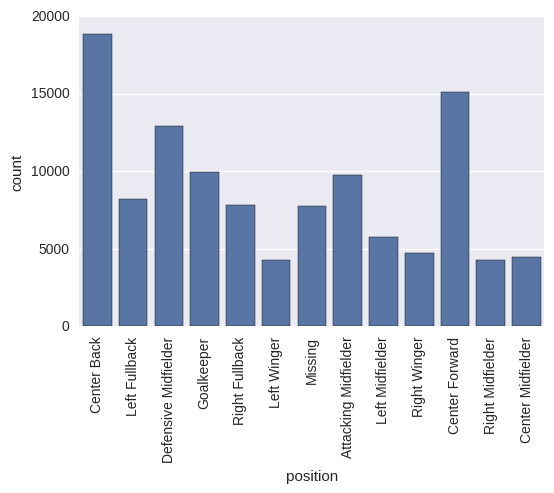

In [144]:
hist = sb.countplot(x='position', data=data_skin, color=plot_color)
pl.setp(hist.get_xticklabels(), rotation=90)
hist

#### `refCountry` and `Alpha_3`

There is a bijection between `refCountry` and `Alpha_3`, so we will drop the `Alpha_3` column.

In [145]:
data_skin = data_skin.drop('Alpha_3', axis=1)

#### Photo ID

Let's also drop the `photoID` column, since we don't have access to the photos anyways:

In [146]:
data_skin = data_skin.drop('photoID', axis=1)

#### Player name

We don't need this, since we already have the short name.

In [147]:
data_skin = data_skin.drop('player', axis=1)

#### Final observation

After our preprocessing, we have this proportion of `null` values:

In [148]:
1 - len(data_skin.dropna()) / len(data_skin)

0.006455182589450437

Since that's less than 1%, we can just drop those values:

In [149]:
data_skin = data_skin.dropna()

### 0c - Dealing with categorical attributes

Scikit-learn does not accept categorical values as is; we need to translate them into arbitrary numerical values with the following helper:

In [150]:
from sklearn import preprocessing
def categ_to_numeric(column):
    """Transforms a categorical column into numerical values."""
    enc = preprocessing.LabelEncoder()
    enc.fit(column)
    return enc.transform(column)

And apply it to the following columns:

In [151]:
categ_features = ['playerShort', 'club', 'leagueCountry', 'position', 'skin']
for c in categ_features:
    data_skin[c] = categ_to_numeric(data_skin[c])

In [152]:
data_skin[categ_features].head()

,playerShort,club,leagueCountry,position,skin
5,0,33,0,1,1
6,42,47,0,6,1
7,61,53,0,4,8
8,86,48,0,5,2
9,100,2,2,10,0


### 0d - Standardization of numerical values

We will now standardize some numerical columns: we take the mean, subtract it from every value and then scale the values with the standard deviation:

In [153]:
def standardize_feature(column):
    """Standardizes a numerical column."""
    enc = preprocessing.StandardScaler()
    enc.fit(column)
    return enc.transform(column)

We apply this to the following columns:

In [154]:
standard_features = ['age', 'height', 'weight']
for c in standard_features:
    data_skin[c] = standardize_feature(data_skin[c])

/home/mukel/Applications/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mukel/Applications/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mukel/Applications/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mukel/Applications/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as 

In [155]:
data_skin[standard_features].head()

,age,height,weight
5,1.360303,-0.014136,-0.742143
6,-0.028845,0.721872,0.514662
7,-0.260369,-0.308539,-1.161078
8,0.202680,1.605081,0.514662
9,-0.491894,-0.308539,-0.881788


### 0e - Preprocessing result

In [156]:
data_skin.sample(10)

,playerShort,club,leagueCountry,height,weight,position,games,victories,ties,defeats,...,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin,darker_skin,age
64682,792,51,3,0.133065,-0.602498,0,4,0,0,4,...,3,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,5,False,0.897254
85771,568,15,2,0.869073,1.212887,4,1,1,0,0,...,55,0.357363,367.0,0.001099,0.449468,376.0,0.004877,0,True,-1.186468
62228,1067,9,3,-1.927757,-1.859302,12,1,0,1,0,...,55,0.357363,367.0,0.001099,0.449468,376.0,0.004877,0,True,-1.649517
123562,950,16,2,-0.897346,-1.719657,0,1,1,0,0,...,31,0.368946,2411.0,0.000173,0.637172,2475.0,0.000913,2,True,-1.649517
142461,1475,37,2,0.574670,0.654307,5,1,0,0,1,...,8,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,2,True,-0.954943
121106,920,90,0,-0.014136,0.654307,2,3,2,0,1,...,64,0.352920,5952.0,0.000070,0.445679,6121.0,0.000269,7,False,0.897254
24364,525,6,0,-0.455741,-1.161078,12,1,1,0,0,...,3,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,6,False,-0.491894
31593,372,28,3,-1.044547,-1.021433,2,1,0,1,0,...,27,0.385082,537.0,0.000756,0.859431,562.0,0.003620,2,True,0.897254
5957,416,51,3,-1.044547,-0.742143,7,6,3,2,1,...,3,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,2,True,1.128779
4717,982,58,1,0.869073,-0.043918,4,5,2,2,1,...,7,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,1,True,0.665729


## Part 1 - Skin color classifier

### 1a- Features and target

We take care to drop the player's name, as it could introduce bias.

In [157]:
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [158]:
observations = data_skin.groupby(['playerShort']).mean()

player_features = ['club', 'leagueCountry', 'height', 'weight', 'position', 'goals', 'age', 'darker_skin']

observations = observations[player_features]
observations.sample(10)

,club,leagueCountry,height,weight,position,goals,age,darker_skin
playerShort,,,,,,,,
279,8.0,0.0,1.163476,0.933597,2.0,1.108108,-1.186468,False
94,57.0,1.0,0.574670,1.073242,2.0,1.262500,-0.028845,True
1405,33.0,0.0,-0.161338,0.095727,10.0,0.017699,0.434205,True
616,1.0,2.0,0.574670,0.793952,2.0,1.112903,1.128779,True
1322,44.0,0.0,2.046686,1.212887,1.0,0.083333,-1.186468,True
635,47.0,0.0,-1.780555,-1.300723,11.0,0.466102,-0.260369,True
229,33.0,0.0,0.574670,-0.881788,12.0,0.821782,-0.028845,True
218,15.0,2.0,0.427468,-0.323208,9.0,0.187500,-1.881042,True
400,58.0,1.0,0.869073,1.631822,1.0,0.201493,1.128779,True


Since we want to predict the binary skin label (`darker_skin`), we need to drop it in the features matrix, and isolate it as a vector.

In [159]:
target = 1 * np.array(observations.darker_skin)
observations = observations.drop('darker_skin', axis=1)
target

array([1, 1, 1, ..., 0, 1, 1])

### 1b - Constructing and assessing a model

#### Number of estimators

We will test the accuracy for an increasing number of trees in the forest.<br>
We perform a 5-fold cross-validation.

[ 0.7498296   0.79530185  0.81322623  0.82730445  0.83309802  0.83820188]


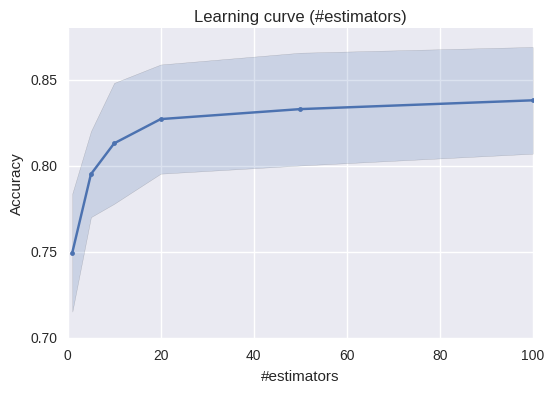

In [160]:
n_estim = [1, 5, 10, 20, 50, 100]

pl.title("Learning curve (#estimators)")
pl.xlabel('#estimators')
pl.ylabel('Accuracy')

means = []
stds = []
for n in n_estim:
    model = RandomForestClassifier(n_estimators=n)
    scores = cross_validation.cross_val_score(model, observations, target, cv=20, n_jobs=-1)
    means.append(scores.mean())
    stds.append(scores.std())
    #print('Finished forest with', str(n), 'trees.')        
stds = np.array(stds)
means = np.array(means)
print(means)
pl.plot(n_estim, means, marker='.')
pl.fill_between(n_estim, means - stds, means + stds, alpha=.2)

In this case, n = 50 gives an accuracy of 82.9% for binary (dark/light) skin color prediction. n = 100 yields a 83.1% accuracy.<br>
We will keep 50 as our value for n.

#### Max features

We can also tune the maximum number of features we allow the classifier to use.<br>
The default number is `sqrt(n)` where `n` is the total number of features.<br>
In our case, n = 22, so the classifier uses 5 features at each split.<br><br>

The accuracy with 5 features is 76%/83%, so we consider this satisfying.<br>
If we increase this number, the quality of the model will improve but the time used to compute it will increase as well.

#### Feature importances

We are looking to assess the importance of each feature in the classification.

In [161]:
forest = RandomForestClassifier(n_estimators=50).fit(observations, target)

The following code is adapted from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

Feature ranking:
1. goals (0.209394)
2. club (0.163916)
3. weight (0.145676)
4. height (0.141818)
5. age (0.136312)
6. leagueCountry (0.101882)
7. position (0.101002)


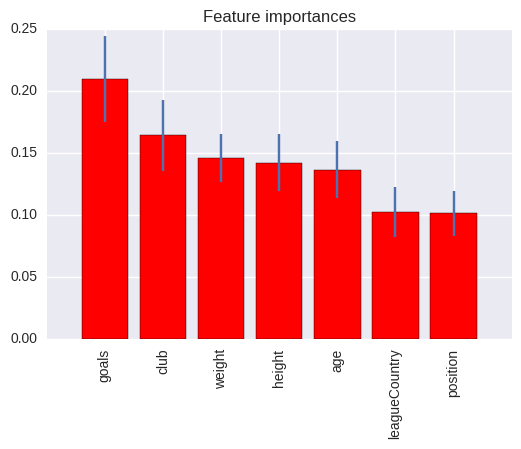

In [162]:
importances = forest.feature_importances_
importances_std = std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
features = observations.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(observations.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(observations.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pl.xticks(range(observations.shape[1]), [features[i] for i in indices], rotation=90)
pl.xlim([-1, observations.shape[1]])
pl.show()

It seems that the features that add the most information in the classification are `goals`, `club`, `weight`, `height`, `age`, `leagueCountry` and `position` in that order.

## Part 2 - Clustering

Aggregate referee-related data. 'refNum' and 'refCountry' are categorical, thus excluded. The player 'skin' color is also preserved.

In [163]:

referee_data = ['meanIAT', 'nIAT', 'meanExp', 'nExp', 'seIAT', 'seExp']
X = data_skin.groupby(['playerShort'])[['skin'] + referee_data].mean()
X.head()

,skin,meanIAT,nIAT,meanExp,nExp,seIAT,seExp
playerShort,,,,,,,
0,1,0.344759,20088.589744,0.487879,21033.250000,0.000333,0.001553
1,1,0.349332,26877.147368,0.453989,27659.842105,0.000226,0.001025
2,2,0.345893,21234.861386,0.491482,22238.742574,0.000367,0.002032
3,0,0.346790,40568.571429,0.511650,42088.153061,0.000525,0.002938
4,2,0.331600,2832.351351,0.335587,2953.837838,0.001488,0.005296


In [164]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

Given a classification/clustering computes the correlation with the skin color.

In [165]:
def skin_color_score(X, cluster_labels):
    """
    Computes the how related is the clusters to the skin colors (light/dark).
    Neutral skin colors are not taken into account.
    """
    skin = X.skin
    W = skin[cluster_labels == 0]
    B = skin[cluster_labels == 1]
    white_count = (skin < 4).sum()
    black_count = (skin > 4).sum()
    return ((W < 4).sum() / white_count + (B > 4).sum() / black_count) / 2

In [166]:
def skin_color_correlation(X, cluster_labels):
    # Our clustering algorithm doesn't distinguish between dark or light.
    # So we have to test both assignments.
    return max(skin_color_score(X, cluster_labels), skin_color_score(X, 1 - cluster_labels))

def compute_scores(X, columns):
    """Computes the clustering score for a given subset of columns."""
    clusterer = KMeans(n_clusters=2, random_state=10)
    cluster_labels = clusterer.fit_predict(X[columns])
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X[columns], cluster_labels)
    return silhouette_avg, skin_color_correlation(X, cluster_labels)

In [167]:
single_scores = [(f,) + compute_scores(X, [f]) for f in X.columns]

In [168]:
sorted(single_scores, key=lambda tup: tup[2], reverse=True)

[('skin', 0.71690625032040844, 1.0),
 ('meanExp', 0.61240355191635953, 0.63467295567213744),
 ('meanIAT', 0.62021620047149217, 0.62626782820747307),
 ('seExp', 0.81972763781885194, 0.60943671688245016),
 ('seIAT', 0.84345221190641562, 0.60457236367136735),
 ('nIAT', 0.8170322619542516, 0.51480643660457881),
 ('nExp', 0.72970184326197363, 0.51446631692095424)]

We discard `nIAT` and `nExp` since their clustering scores are unrelated to skin color (random).

Instead of removing one by one, we can just test all possible combinations.
There are only 15 non-empty possibilities.

In [169]:
import itertools
best_features = ['meanExp', 'meanIAT', 'seExp', 'seIAT']

def all_subsets(elems):
    for L in range(1, len(elems)+1):
        for subset in itertools.combinations(elems, L):
            yield subset

for x in all_subsets(best_features):
        print(x, compute_scores(X, list(x)))

('meanExp',) (0.61240355191635953, 0.63467295567213744)
('meanIAT',) (0.62021620047149217, 0.62626782820747307)
('seExp',) (0.81972763781885194, 0.60943671688245016)
('seIAT',) (0.84345221190641562, 0.60457236367136735)
('meanExp', 'meanIAT') (0.60860572605256169, 0.63277181498772683)
('meanExp', 'seExp') (0.61089743059442281, 0.63467295567213744)
('meanExp', 'seIAT') (0.6123140095290488, 0.63467295567213744)
('meanIAT', 'seExp') (0.58987078151968442, 0.62626782820747307)
('meanIAT', 'seIAT') (0.61769309768487302, 0.62626782820747307)
('seExp', 'seIAT') (0.81982033914901453, 0.60943671688245016)
('meanExp', 'meanIAT', 'seExp') (0.60734951648637936, 0.63277181498772683)
('meanExp', 'meanIAT', 'seIAT') (0.60854522538935818, 0.63277181498772683)
('meanExp', 'seExp', 'seIAT') (0.61089228367114878, 0.63467295567213744)
('meanIAT', 'seExp', 'seIAT') (0.58904495359858589, 0.62626782820747307)
('meanExp', 'meanIAT', 'seExp', 'seIAT') (0.60730472544843217, 0.63277181498772683)


So, by just keeping `meanExp` we obtain a 63% accuracy on the prediction, while having a 0.61 silhouette score.